# A quick Lithospheric Model with visco-plastic non-linear rheologies

version 0.1
Romain Beucher
romain.beucher@unimelb.edu.au

In [1]:
import unsupported.geodynamics as GEO
import glucifer

/root/underworld2/unsupported/scaling/__init__.py:13: UserWarning: 

    The scaling module is not supported.

    It requires 'pint' as a dependency.

    You can install pint by running:

    'pip install pint' in a terminal

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """
/root/underworld2/unsupported/lithopress/__init__.py:8: UserWarning: 

The lithopress module is not supported.

Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """
/root/underworld2/unsupported/LecodeIsostasy/__init__.py:10: UserWarning: 

    The LecodeIsostasy module is not supported.

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """


In [2]:
u = GEO.UnitRegistry

In [3]:
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
model_height = 120e3 * u.meter
refViscosity = 1e24 * u.pascal * u.second
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.sca.scaling["[length]"] = KL
GEO.sca.scaling["[time]"] = Kt
GEO.sca.scaling["[mass]"]= KM
GEO.sca.scaling["[temperature]"] = KT

# Define the external geometry

In [4]:
elementType = "Q1/dQ0"
elementRes = (180, 60)
minCoord = (0. * u.kilometer, -110. * u.kilometer)
maxCoord = (360. * u.kilometer, 10. * u.kilometer)
gravity = (0.0, -9.81 * u.meter / u.second**2)

Model = GEO.Model(elementType=elementType, elementRes=elementRes, minCoord=minCoord, maxCoord=maxCoord, periodic=(False, False), gravity=gravity)

# Add some Materials

In [5]:
minX = minCoord[0]
maxX = maxCoord[0]

global_diffusivity = 1e-6 * u.metre**2 / u.second 
global_cp = 1000. * u.joule / (u.kelvin * u.kilogram)
global_expansivity = 3e-5 / u.kelvin

# Fault
vertices = [(169.  * u.kilometer,  0. * u.kilometer),
            (171. * u.kilometer,  0. * u.kilometer),
            (191. * u.kilometer, -20. * u.kilometer),
            (189. * u.kilometer, -20. * u.kilometer)]

fault = Model.add_material(name="Fault", vertices=vertices)
fault.density = 2620. * u.kilogram / u.metre**3
fault.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
fault.capacity = global_cp
fault.diffusivity = global_diffusivity
fault.thermalExpansivity = global_expansivity


# Air Layer
top = maxCoord[1]
bottom = 0. * u.kilometer
air = Model.add_material(name="Air", vertices=[(minX, bottom),(minX, top),(maxX, top),(maxX, bottom)])
air.density = 1. * u.kilogram / u.metre**3
air.radiogenicHeatProd = 0.0
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
air.diffusivity = global_diffusivity
air.thermalExpansivity = 0.0

 
top    = 0.  * u.kilometer
bottom = -20. * u.kilometer
uppercrust = Model.add_material(name="Upper Crust", vertices=[(minX, bottom),(minX, top),(maxX, top),(maxX, bottom)])
uppercrust.density  = 2620. * u.kilogram / u.metre**3
uppercrust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
uppercrust.capacity = global_cp
uppercrust.diffusivity = global_diffusivity
uppercrust.thermalExpansivity = global_expansivity
                  
top      = -20. * u.kilometer
bottom   = -25. * u.kilometer
midcrust = Model.add_material(name="Mid Crust", vertices=[(minX, bottom),(minX, top),(maxX, top),(maxX, bottom)])
midcrust.density = 2900. * u.kilogram / u.metre**3
midcrust.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3
midcrust.capacity = global_cp
midcrust.diffusivity = global_diffusivity
midcrust.thermalExpansivity = global_expansivity

top    = -35. * u.kilometer
bottom = -40. * u.kilometer
heavycrust = Model.add_material(name="Heavy Crust", vertices=[(minX, bottom),(minX, top),(maxX, top),(maxX, bottom)])
heavycrust.density  = 2900. * u.kilogram / u.metre**3
heavycrust.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3
heavycrust.capacity = global_cp
heavycrust.diffusivity = global_diffusivity
heavycrust.thermalExpansivity = global_expansivity


top    = -25. * u.kilometer
bottom = -60. * u.kilometer
lowercrust = Model.add_material(name="Lower Crust", vertices=[(minX, bottom),(minX, top),(maxX, top),(maxX, bottom)])
lowercrust.density  = 2800. * u.kilogram / u.metre**3
lowercrust.radiogenicHeatProd = 0.4 * u.microwatt / u.meter**3
lowercrust.capacity = global_cp
lowercrust.diffusivity = global_diffusivity
lowercrust.thermalExpansivity = global_expansivity


top        = -60. * u.kilometer
bottom     = -110. * u.kilometer
mantle = Model.add_material(name="Mantle", vertices=[(minX, bottom),(minX, top),(maxX, top),(maxX, bottom)])
mantle.density = 3370. * u.kilogram / u.metre**3
mantle.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3
mantle.capacity = global_cp
mantle.diffusivity = global_diffusivity
mantle.thermalExpansivity = global_expansivity

In [6]:
import underworld.function as fn
import underworld as uw
import numpy as np

In [7]:
uw.function.shape.Polygon(np.array([(0.0,0.0), (1.0, 0.0), (1.0, 1.0), (1.0, 0.0), (0.0, 0.0)]))

In [8]:
Fig = Model.plot_material()


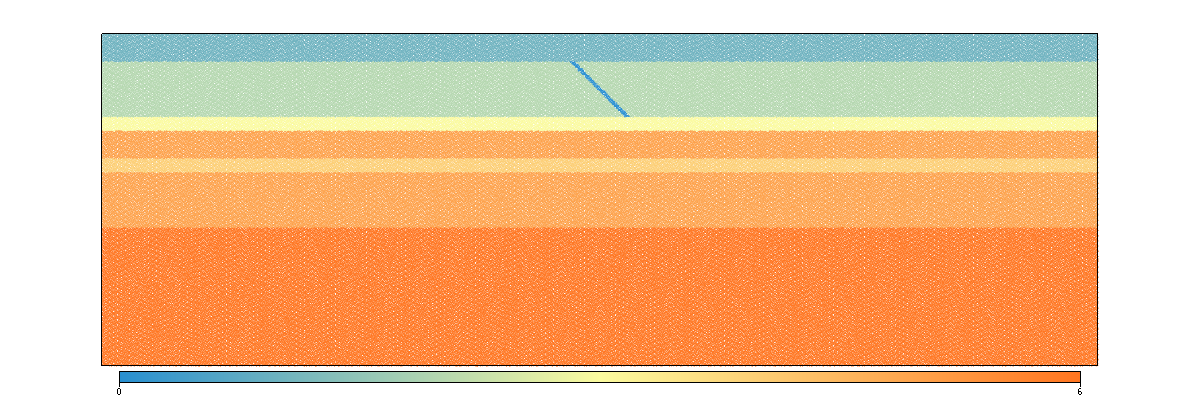

In [9]:
Fig.show()

# Define Viscosities

In [10]:
air.viscosity        = 1e19 * u.pascal * u.second
uppercrust.viscosity = "Patterson et al., 1990"
midcrust.viscosity   = "Goetze et al., 1978"
lowercrust.viscosity = "Wang et al., 2012"
heavycrust.viscosity = "Goetze et al., 1978"
mantle.viscosity     = 1e23 * u.pascal * u.second
fault.viscosity      = 1e19 * u.pascal * u.second

On can also define is own rheology as follow:

In [11]:
myRheology = {}

# Define Plasticity

In [12]:
uppercrust.plasticity = "Rey et al., 2010 (UpperCrust)"
midcrust.plasticity   = "Rey et al., 2010 (UpperCrust)"
lowercrust.plasticity = "Rey et al., 2010 (LowerCrust)"
heavycrust.plasticity = "Rey et al., 2010 (LowerCrust)"
fault.plasticity      = "Rey et al., 2010 (Mantle)"

## Temperature Boundary Condition

In [13]:
Model.set_temperatureBCs(top=293.15 * u.degK, bottom=1603.15 * u.degK, indexSets=[(mantle.indices, 1603.15 * u.degK), (air.indices, 293.15 * u.degK )])

In [14]:
Model.solve_temperature_steady_state()


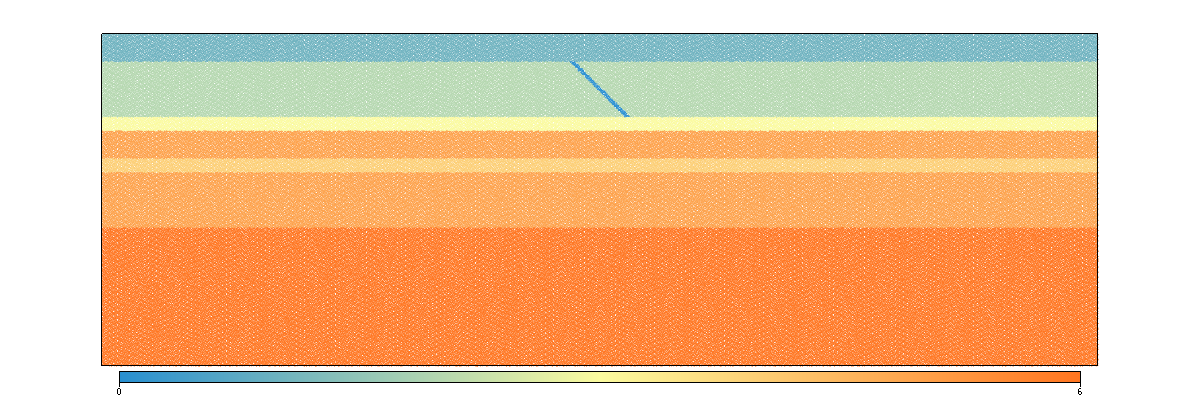

In [15]:
Fig.show()

## Velocity Boundary Conditions

In [16]:
Model.set_velocityBCs(left=[-1.8 * u.centimeter / u.year, 0.],
                      right=[1.8 * u.centimeter / u.year, 0.],
                      bottom=[None, 0.0])


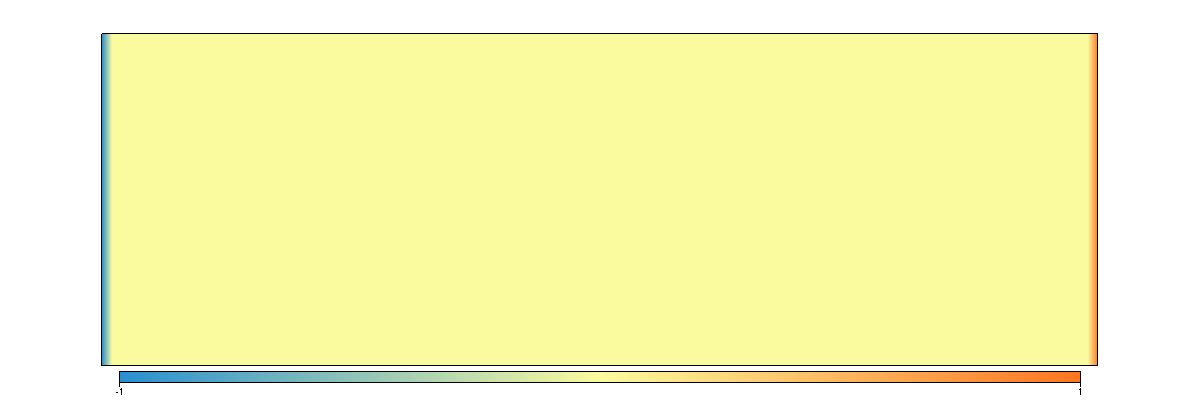

In [17]:
Fig = Model.plot_velocity()
Fig.show()

## Stress Boundary Conditions (To-do)

In [18]:
Model.solve_lithostatic_pressure()

In [19]:
Fig = Model.plot_pressure()


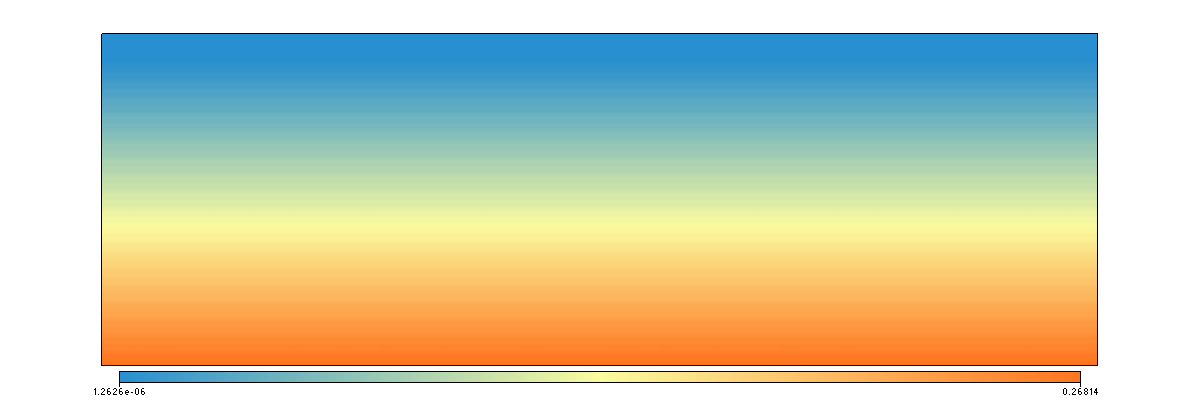

In [20]:
Fig.show()

## Run Model

In [21]:
Model.init_advection_diffusion()

In [22]:
Model.init_stokes_system()

In [23]:
Fig = Model.plot_viscosity()


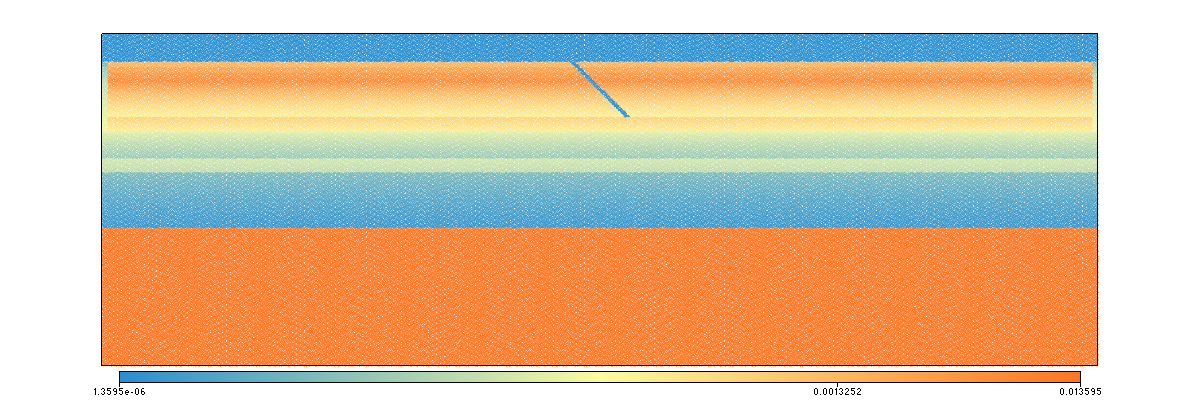

In [24]:
Fig.show()

In [25]:
Model.run_for(10.* u.years)

Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9



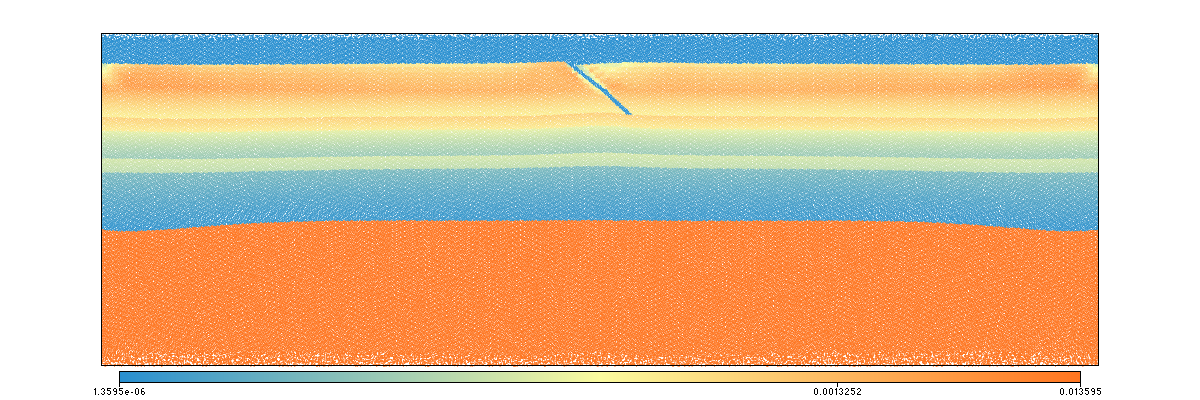

In [26]:
Fig.show()

In [27]:
FigVelocity = glucifer.Figure(figsize=(1200,400))
FigVelocity.append(glucifer.objects.Points(Model.swarm, Model.material, pointSize=3.0))
FigVelocity.append(glucifer.objects.VectorArrows(Model.mesh, Model.velocity, scaling=0.03, arrowHead=10., resolutionI=25, resolutionJ=10)) 


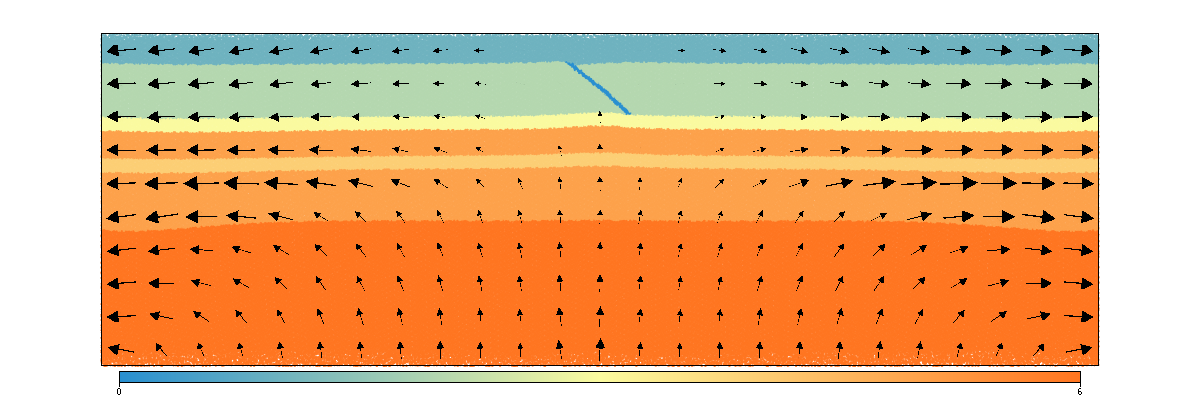

In [28]:
FigVelocity.show()